In [1]:
import os
os.chdir('/home/david/Projects/optogenetic_whole_cell_activation/morph_impact_on_opt_stim')
import numpy as np
import pandas as pd
from neuron import h
from neurostim.cell import Cell
from neurostim.light_classes import LightSource, LightStimulation
from neurostim.utils import convert_polar_to_cartesian_xz, interpolate
from neurostim.polarmaps import get_AP_times, simple_polar_map
import copy
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

def step_round(a, step):
    return np.round(np.array(a, dtype=float) / step) * step

In [2]:
# format
# dimensions (A4:  8.27 x 11.69 inches)
text_frac = 0.8
abs_pw = 8.27 # pagewidth
abs_pl = 11.69 # pagelength
pw = text_frac * abs_pw
pl = text_frac * abs_pl
# others
dpi=600

In [3]:
hoc_file = 'L5'
plot_path = 'paper/NEW_FIGURES/FIG3/plots/'+hoc_file+'_'

#light_powers = [5e-5, 1e-4, 5e-4, 1e-3, 5e-3]
#light_powers = [1e-4, 1e-3, 5e-3]
light_powers = [5e-5, 1e-3, 5e-3]

In [4]:
# model config 1 ---- *** DO NOT RERUN ***
# NEURON simulator setup is corrupted if reinitialized in a running kernel, rerun complete notebook

# cortical depth of neuron models
cortical_depth = {'L23': 400, 'L5': 1170} #um

# ChR2 expression distribution and level
chanrhod_distribution = 'uniform' 
chanrhod_soma_density = 13e9

# NEURON setup
h.load_file("stdrun.hoc")
h.cvode_active(1)
# load cell and create stimulation object
cell = Cell(
    hoc_file="simneurostim/model/hoc/" + str(hoc_file) + ".hoc",
    cortical_depth=cortical_depth,
    ChR_soma_density=chanrhod_soma_density,
    ChR_distribution=str(chanrhod_distribution)
)

	1 
	1 
	1 
	1 


In [5]:
# model config 2 (can be adapted and rerun without restarting notebook kernel)

# light source model and params
light_model = 'foutz_et_al2012'
fiber_diameter = 200 #um
fiber_NA = 0.22
# stimulation duration
light_duration = 200 # ms
# other params
light_delay = 1 #ms
tot_rec_time = light_delay + light_duration + 10
AP_threshold = 0 # mV
interpol_dt = 0.1 # ms

def setup_stimulation(radius, angle, light_power, 
                      light_delay=light_delay, light_duration=light_duration, light_model=light_model, 
                      fiber_diameter=fiber_diameter, fiber_NA=fiber_NA, cell=cell): 
    # light source initialization
    light_x, light_y = convert_polar_to_cartesian_xz(radius, angle)
    light_z = 0  # cortical surface
    light_pos = (light_x, light_y, light_z)
    light_source = LightSource(
        model=str(light_model),
        position=(light_x, light_y, light_z),
        width=float(fiber_diameter),
        NA=float(fiber_NA)
    )
    # stimulation object initialization
    light_stim = LightStimulation(
        cell=cell,
        light_source=light_source,
        delay=float(light_delay),
        duration=float(light_duration),
        light_power=float(light_power),
        record_all_segments=False,
    )
    return light_source, light_stim

def stimulate_and_measure(radius, angle, light_power, rec_vars):
    # initialize light source and stim with standard params
    light_source, light_stim = setup_stimulation(radius, angle, light_power)
    # simulate
    measurement = pd.DataFrame(
        light_stim.simulate_and_measure(
            tot_rec_time=float(tot_rec_time),
            extra_rec_var_names=rec_vars[0],
            extra_rec_var_pointers=[eval(item) for item in rec_vars[1]],
        )
    )
    # dealing with drop full row duplicates
    # drop completely redundant duplicates
    measurement = measurement.drop_duplicates()
    # add 1e-12 ms to 2nd entry time point of duplicate entries with the same time but different (e.g. Vm) values
    measurement.loc[measurement["time [ms]"].diff() == 0, "time [ms]"] += 1e-12
    # interpolate simulation results
    measurement = interpolate(
        df=measurement, interpolation_dt=float(interpol_dt)
    )
    return measurement

# define measurement variables
segs = [seg for sec in h.allsec() for seg in sec][:-1] # exclude last seg as it is the light source
segcatpointernames_g = [str(seg) for seg in segs]
segcatpointers_g = ['h.'+str(seg)+'._ref_gcat_chanrhod' for seg in segs]
segcatpointernames_v = [str(seg)+'_V' for seg in segs]
segcatpointers_v = ['h.'+str(seg)+'._ref_v' for seg in segs]
segcatpointernames = segcatpointernames_g + segcatpointernames_v 
segcatpointers = segcatpointers_g + segcatpointers_v

radii = [0,100,200,300,400,500]
angles = [0]#,np.pi/2,np.pi,np.pi*3/2]
angles = [0,np.pi/2,np.pi,np.pi*3/2]

res = []
for light_power in light_powers:
    print("simulated 1 lp step")
    for radius in radii:
        for angle in angles:
            measurement = stimulate_and_measure(radius, angle, light_power, rec_vars=[segcatpointernames,segcatpointers])
            # convert density conductance into real conductance for each segment
            for seg, seg_gcat in zip(segs, segcatpointernames):
                measurement[seg_gcat] *= eval('h.'+str(seg)+'.area()') * 1e-8 # eval area of segment and convert from um2 to cm2
            t_sec_g = pd.melt(measurement, id_vars=['time [ms]'], value_vars=segcatpointernames_g).set_index(['variable', 'time [ms]'])
            # take mean of conductance over time for each compartment
            total_sec_g = t_sec_g.groupby('variable').mean()
            # get AP count of spikes in each segment
            total_sec_g['APC_seg'] = t_sec_g.groupby('variable').apply(
                lambda x: len(get_AP_times(measurement, interpol_dt=0.1, AP_threshold=0, t_on=light_delay, apply_to=x.name))
            )
            #total_sec_g['g_normalized'] = total_sec_g / total_sec_g.sum()
            total_sec_g['light_power'] = light_power
            total_sec_g['radius']=radius
            total_sec_g['angle']=angle
            total_sec_g['APC'] = len(get_AP_times(measurement, interpol_dt=0.1, AP_threshold=0, t_on=light_delay))
            res.append(total_sec_g)
total_sec_g = pd.concat(res)
total_sec_g = total_sec_g.reset_index()

simulated 1 lp step
simulated 1 lp step
simulated 1 lp step


In [6]:
total_sec_g

,variable,value,APC_seg,light_power,radius,angle,APC
0,ais[0](0.05),3.265252e-14,2,0.00005,0,0.000000,0
1,ais[0](0.15),3.227652e-14,2,0.00005,0,0.000000,0
2,ais[0](0.25),3.184991e-14,2,0.00005,0,0.000000,0
3,ais[0](0.35),3.142432e-14,2,0.00005,0,0.000000,0
4,ais[0](0.45),3.099976e-14,2,0.00005,0,0.000000,0
...,...,...,...,...,...,...,...
60115,soma(0.55),6.559903e-13,2,0.00500,500,4.712389,1
60116,soma(0.65),6.725710e-13,2,0.00500,500,4.712389,1
60117,soma(0.75),6.791037e-13,2,0.00500,500,4.712389,1
60118,soma(0.85),5.740411e-13,2,0.00500,500,4.712389,1


In [6]:
# function to label compartment type
def compartment_converter(seg):
    if 'ais' in str(seg):
        return 'soma/basal/axon'
    elif 'soma' in str(seg):
        return 'soma/basal/axon'
    elif 'dend11' in str(seg):
        if eval('h.'+str(seg)+'.z_chanrhod') < -300:
            return 'apical shaft'
        else:
            return 'apical'
    elif 'dend' in str(seg):
        return 'soma/basal/axon'
    elif 'myelin' in str(seg):
        return 'soma/basal/axon'
    elif 'nakeaxon' in str(seg):
        return 'soma/basal/axon'
    elif 'node' in str(seg):
        return 'soma/basal/axon'
    elif 'hill' in str(seg):
        return 'soma/basal/axon'
    else:
        return 'None'# function to label compartment type

def compartment_converter(seg):
    if 'ais' in str(seg):
        return 'soma/basal/axon'
    elif 'soma' in str(seg):
        return 'soma/basal/axon'
    elif 'dend11' in str(seg):
        if eval('h.'+str(seg)+'.z_chanrhod') > -300:
            return 'apical'
        elif eval('h.'+str(seg)+'.z_chanrhod') > -850:
            return 'apical shaft'
        elif eval('h.'+str(seg)+'.z_chanrhod') > -1100 and eval('h.'+str(seg)+'.x_chanrhod')**2+eval('h.'+str(seg)+'.y_chanrhod')**2 < 170:
            return 'apical shaft'
        else:
            return 'soma/basal/axon'
    elif 'dend' in str(seg):
        return 'soma/basal/axon'
    elif 'myelin' in str(seg):
        return 'soma/basal/axon'
    elif 'nakeaxon' in str(seg):
        return 'soma/basal/axon'
    elif 'node' in str(seg):
        return 'soma/basal/axon'
    elif 'hill' in str(seg):
        return 'soma/basal/axon'
    else:
        return 'None'

In [7]:
# calculate light energy absorbed by cell 
light_energy_df = []
light_energy_per_compartment = []
for light_power in light_powers:
    for radius in np.arange(0,1000,25):
        for angle in np.arange(0,2*np.pi,np.pi/8):
            light_source, light_stim = setup_stimulation(radius, angle, light_power)
            segs, Txs = light_stim.get_segs_Txs()
            light_energy = 0
            for seg, Tx in zip(segs, Txs):
                tmp2 = dict()
                tmp2['light_power_seg_uW'] = seg.area() *1e-8 * Tx * light_power * 1e6
                tmp2['light_power'] = light_power
                tmp2['radius'] = radius
                tmp2['angle']=angle
                tmp2['seg']=str(seg)
                light_energy_per_compartment.append(tmp2)
                light_energy += seg.area() * Tx * light_power
            tmp=dict()
            tmp['light_power'] = light_power
            tmp['radius'] = radius
            tmp['angle']=angle
            tmp['light_energy']=light_energy
            light_energy_df.append(tmp)
light_energy_df = pd.DataFrame(light_energy_df)
light_energy_per_compartment = pd.DataFrame(light_energy_per_compartment)

In [8]:
# conductance and light energy absorbed by compartments in one df
cond_light_energy_merged = total_sec_g.rename(columns=dict(variable='seg', value='conductance')).merge(light_energy_per_compartment)
# convert conductance from S to pS
cond_light_energy_merged['conductance'] = cond_light_energy_merged['conductance'] * 1e12 
# take mean over all light source positions and add density-conductance and light intensity in compartments
c_le_stimpositionavrg = cond_light_energy_merged.groupby(['light_power', 'seg'])['conductance', 'light_power_seg_uW','APC'].mean()
c_le_stimpositionavrg['depth'] = [ eval('h.'+seg+'.z_chanrhod') for seg in c_le_stimpositionavrg.reset_index().seg]
c_le_stimpositionavrg['conductance_dens'] = [ cond/eval('h.'+seg+'.area()') for seg, cond in zip(c_le_stimpositionavrg.reset_index().seg, c_le_stimpositionavrg.conductance)]
c_le_stimpositionavrg['light_intensity'] = [ le/eval('h.'+seg+'.area()') for seg, le in zip(c_le_stimpositionavrg.reset_index().seg, c_le_stimpositionavrg.light_power_seg_uW)]
# label comaprtments
c_le_stimpositionavrg['seglabel'] = [compartment_converter(seg) for seg in c_le_stimpositionavrg.reset_index().seg]
c_le_stimpositionavrg
####################
# take average over angles
c_le_angle_avrg = cond_light_energy_merged.groupby(['light_power','seg','radius'])['light_power_seg_uW', 'conductance', 'APC'].mean()
c_le_angle_avrg['seglabel'] = [compartment_converter(seg) for seg in c_le_angle_avrg.reset_index().seg]
c_le_angle_avrg
cond_light_energy_merged['seglabel'] = [compartment_converter(seg) for seg in cond_light_energy_merged.reset_index().seg]
cond_light_energy_merged = cond_light_energy_merged.set_index(['light_power','seg','radius'])

# take max across compartments from conductance (previously averaged over angle already)
max_c_APC_angle_avrg = c_le_angle_avrg.groupby(['light_power','radius'])['conductance', 'APC'].max()

/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  from ipykernel import kernelapp as app
/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


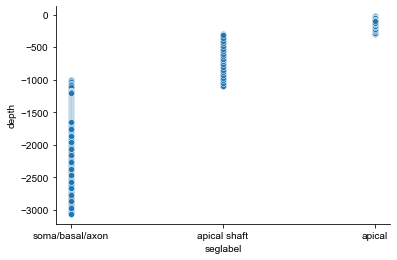

In [9]:
#verify that seglabels are correct think about depth where apical, shaft, basal, soma, axon should be
sns.scatterplot(data=c_le_stimpositionavrg, x='seglabel', y='depth')
plt.show()

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

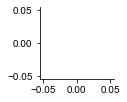

In [10]:
common_hue_order = ['apical','apical shaft','soma/basal','axon']
# plot max of compartments for each variable (y) dep on radial distance of fiber (x)
for lp in light_powers:
    # plot light energy
    fig, ax = plt.subplots(figsize=(pw/5,pw/5))
    sns.scatterplot(
        data=pd.DataFrame(cond_light_energy_merged.loc[lp].groupby(['radius','angle','seglabel'])['light_power_seg_uW'].max()),
        x='radius', y='light_power_seg_uW',hue='seglabel', hue_order=common_hue_order, palette='tab10', legend=False,ax=ax, s=50,
    )
    plt.ylim(0,None)
    plt.xlim(-20,None)
    plt.xlabel('')
    plt.ylabel('')
    fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/max_light_power_seg_uW_comp_radius'+str(lp)+'.png', dpi=dpi, 
                    facecolor=None, edgecolor=None,  
                    bbox_inches='tight')
    plt.show()    
    
    # plot conductance 
    fig, ax = plt.subplots(figsize=(pw/5,pw/5))
    sns.scatterplot(
        data=pd.DataFrame(cond_light_energy_merged.loc[lp].groupby(['radius','angle','seglabel'])['conductance'].max()),
        x='radius', y='conductance',hue='seglabel', hue_order=common_hue_order, palette='tab10', legend=False,ax=ax, s=50,
    )
    plt.ylim(0,None)
    plt.xlim(-20,None)
    plt.xlabel('')
    plt.ylabel('')
    fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/max_cond_comp_radius'+str(lp)+'.png', dpi=dpi, 
                    facecolor=None, edgecolor=None,  
                    bbox_inches='tight')
    plt.show()    
    # plot APC
    fig, ax = plt.subplots(figsize=(pw/5,pw/5))
    dfplot = pd.DataFrame(cond_light_energy_merged.loc[lp].groupby(['radius','angle'])['APC'].max())
    # convert APC to spikes (multiply by 5 since 200 ms stim duration)
    dfplot['APC'] = dfplot['APC'] * 5 
    sns.scatterplot(
        data=dfplot,
        x='radius', y='APC', color='grey', edgecolor='black',linewidth=0.2, legend=False,ax=ax, s=50,
    )
    plt.ylim(0,None)
    plt.xlim(-20,None)
    plt.xlabel('')
    plt.ylabel('')
    fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/APC_radius'+str(lp)+'.png', dpi=dpi, 
                    facecolor=None, edgecolor=None,  
                    bbox_inches='tight')
    plt.show()

In [ ]:
# transition from light energy to conductance
# plot ChR cond for each compartment dep on light energy absorbed by compartment
common_hue_order = ['apical','apical shaft','soma/basal','axon']
for lp,xtick in zip(light_powers,[0.2,2,10]):
    fig, ax = plt.subplots(figsize=(pw/8,pw/8))
    sns.scatterplot(
        #data=cond_light_energy_merged.loc[lp],
        data=pd.DataFrame(cond_light_energy_merged.loc[lp].groupby(['radius','angle','seglabel'])['conductance', 'light_power_seg_uW'].max()),
        x='light_power_seg_uW', y='conductance',hue='seglabel', hue_order=common_hue_order, palette='tab10', ax=ax, legend=False, s=50,
    )
    plt.xticks([0,xtick])
    plt.ylim(0,None)
    plt.xlim(0,None)
    plt.xlabel('')
    plt.ylabel('')
    fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/trans1_cond_comp_light_power_seg_uW_comp'+str(lp)+'.png', dpi=dpi, 
                facecolor=None, edgecolor=None,  
                bbox_inches='tight')
    plt.show()

In [ ]:
# transition from conductance into neural response
# plot neural response dep on maximal ChR conductance across compartments
for lp in light_powers:
    fig, ax = plt.subplots(figsize=(pw/8,pw/8))
    dfplot = cond_light_energy_merged.loc[lp].groupby(['radius','angle'])['conductance','APC'].max().reset_index()
    # convert APC to spikes (multiply by 5 since 200 ms stim duration)
    dfplot['APC'] = dfplot['APC'] * 5 
    sns.scatterplot(
        data=dfplot,
        x='conductance', y='APC', color='grey', linewidth=0, edgecolor='black',ax=ax, s=40
    )
    plt.ylim(0,None)
    plt.xlim(0,None)
    plt.xlabel('')
    plt.ylabel('')
    fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/trans2_neural_resp_max_cond_comp'+str(lp)+'.png', dpi=dpi, 
                facecolor=None, edgecolor=None,  
                bbox_inches='tight')
    plt.show()

In [ ]:
# transition from light energy to conductance
# plot ChR cond for each compartment dep on light energy absorbed by compartment
fig, ax = plt.subplots(figsize=(pw/3,pw/5))
sns.scatterplot(
    data=pd.DataFrame(cond_light_energy_merged.groupby(['light_power','radius','angle','seglabel'])['conductance', 'light_power_seg_uW'].max()),
    x='light_power_seg_uW', y='conductance',style='light_power',hue='seglabel', hue_order=common_hue_order, palette='tab10', ax=ax, legend='brief', s=50,
)
plt.ylim(0,None)
plt.xlim(0,None)
plt.xlabel('')
plt.ylabel('')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/trans1_cond_comp_light_power_seg_uW_comp_ALL.svg', dpi=dpi, 
#            facecolor=None, edgecolor=None,  
#            bbox_inches='tight')
plt.show()
fig, ax = plt.subplots(figsize=(pw/9,pw/15))
sns.scatterplot(
    data=pd.DataFrame(cond_light_energy_merged.groupby(['light_power','radius','angle','seglabel'])['conductance', 'light_power_seg_uW'].max()),
    x='light_power_seg_uW', y='conductance',style='light_power',hue='seglabel', hue_order=common_hue_order, palette='tab10', ax=ax, legend=False, s=20,
)
plt.ylim(0,100)
plt.xlim(0,0.5)
plt.xlabel('')
plt.ylabel('')
#fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/trans1_cond_comp_light_power_seg_uW_comp_ALLINSET.png', dpi=dpi, 
#            facecolor=None, edgecolor=None,  
#            bbox_inches='tight')
plt.show()

In [ ]:
cond_light_energy_merged['light_intensity_seg']= [lp_comp/eval('h.'+seg+'.area()') for seg, lp_comp in zip(cond_light_energy_merged.reset_index().seg, cond_light_energy_merged.light_power_seg_uW)]

In [ ]:
cond_light_energy_merged

In [ ]:
# transition from light energy to conductance
# plot ChR cond for each compartment dep on light energy absorbed by compartment
fig, ax = plt.subplots(figsize=(pw/3,pw/5))
sns.scatterplot(
    data=pd.DataFrame(cond_light_energy_merged.groupby(['light_power','radius','angle','seglabel'])['conductance', 'light_intensity_seg'].max()),
    x='light_intensity_seg', y='conductance',style='light_power',hue='seglabel', hue_order=common_hue_order, palette='tab10', ax=ax, legend='brief', s=50,
)
plt.ylim(0,None)
plt.xlim(0,None)
plt.xlabel('')
plt.ylabel('')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/trans1_cond_comp_light_power_seg_uW_comp_ALL.svg', dpi=dpi, 
#            facecolor=None, edgecolor=None,  
#            bbox_inches='tight')
plt.show()
fig, ax = plt.subplots(figsize=(pw/9,pw/15))
sns.scatterplot(
    data=pd.DataFrame(cond_light_energy_merged.groupby(['light_power','radius','angle','seglabel'])['conductance', 'light_power_seg_uW'].max()),
    x='light_power_seg_uW', y='conductance',style='light_power',hue='seglabel', hue_order=common_hue_order, palette='tab10', ax=ax, legend=False, s=20,
)
plt.ylim(0,100)
plt.xlim(0,0.5)
plt.xlabel('')
plt.ylabel('')
#fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/trans1_cond_comp_light_power_seg_uW_comp_ALLINSET.png', dpi=dpi, 
#            facecolor=None, edgecolor=None,  
#            bbox_inches='tight')
plt.show()

In [ ]:
# transition from conductance into neural response
# plot neural response dep on maximal ChR conductance across compartments
fig, ax = plt.subplots(figsize=(pw/5,pw/5))
dfplot = cond_light_energy_merged.groupby(['light_power','radius','angle'])['conductance','APC'].max().reset_index()
# convert APC to spikes (multiply by 5 since 200 ms stim duration)
dfplot['APC'] = dfplot['APC'] * 5 
sns.scatterplot(
    data=dfplot,
    x='conductance', y='APC', hue='light_power', hue_order=[0.00005, 0.001, 0.005], palette=['white','grey','black'], edgecolor='black', linewidth=0.5, 
    ax=ax, s=20, legend=False
)
plt.ylim(0,None)
plt.xlim(0,None)
plt.xlabel('')
plt.ylabel('')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='stimulation intensity', labels=['low','intermediate','high'])
fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/trans2_neural_resp_max_cond_comp_ALL.png', dpi=dpi, 
            facecolor=None, edgecolor=None,  
            bbox_inches='tight')
plt.show()

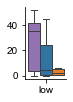

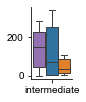

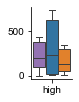

In [11]:
# transition from light energy to conductance
# plot ChR cond for each compartment dep on light energy absorbed by compartment
common_hue_order = ['apical','apical shaft','soma/basal/axon']
for lp,xticklabel in zip(light_powers,['low','intermediate','high']):
    fig, ax = plt.subplots(figsize=(pw/9,pw/5))
    sns.boxplot(
        #data=cond_light_energy_merged.loc[lp],
        data=pd.DataFrame(cond_light_energy_merged.groupby(['light_power','radius','angle','seglabel'])['conductance'].max()).loc[lp,:,:,:].reset_index(),
        x='light_power', y='conductance', hue='seglabel', hue_order=common_hue_order, palette=['tab:purple','tab:blue','tab:orange'], ax=ax, 
        #s=1
        fliersize=0.3, linewidth=1, width=0.9,
        dodge=True,
    )
    ax.get_legend().remove()
    ax.set_xticklabels([xticklabel])
    #plt.ylim(0,None)
    #plt.xlim(0,None)
    plt.xlabel('')
    plt.ylabel('')
    fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/trans1_cond_comps_stim_intensity_BOX_'+str(lp)+'.png', dpi=dpi, 
                facecolor=None, edgecolor=None,  
                bbox_inches='tight')
    plt.show()

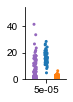

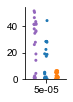

In [41]:
# plot conductance for all compartments in a box for one fiber position
common_hue_order = ['apical','apical shaft','soma/basal/axon']

fig, ax = plt.subplots(figsize=(pw/9,pw/5))
sns.stripplot(
    data=cond_light_energy_merged.reset_index().set_index(['light_power','seg','radius','angle']).loc[5e-5,:,0,0].reset_index(),
    x='light_power', y='conductance', hue='seglabel', hue_order=common_hue_order, palette=['tab:purple','tab:blue','tab:orange'], ax=ax, 
    s=3,
    #fliersize=0.3, linewidth=1, width=0.9, whis=100,
    dodge=True,
)
ax.get_legend().remove()
#ax.set_xticklabels([xticklabel])
plt.ylim(0,55)
#plt.xlim(0,None)
plt.xlabel('')
plt.ylabel('')
fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/cond_comps_central_stim_position_low_light_power_BOX.png', dpi=dpi, 
            facecolor=None, edgecolor=None,  
            bbox_inches='tight')
plt.show()
# plot max conductance across compartments in a box for all fiber positions
common_hue_order = ['apical','apical shaft','soma/basal/axon']

fig, ax = plt.subplots(figsize=(pw/9,pw/5))
sns.stripplot(
    data=pd.DataFrame(cond_light_energy_merged.reset_index().set_index(['light_power','seg','radius','angle']).loc[5e-5,:,:,:].groupby(['light_power','radius','angle','seglabel']).max()).reset_index(),
    x='light_power', y='conductance', hue='seglabel', hue_order=common_hue_order, palette=['tab:purple','tab:blue','tab:orange'], ax=ax, 
    s=3,
    #fliersize=0.3, linewidth=1, width=0.9, whis=100,
    dodge=True,
)
ax.get_legend().remove()
#ax.set_xticklabels([xticklabel])
plt.ylim(0,55)
#plt.xlim(0,None)
plt.xlabel('')
plt.ylabel('')
fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/max_cond_comps_all_stim_positions_low_light_power_BOX.png', dpi=dpi, 
            facecolor=None, edgecolor=None,  
            bbox_inches='tight')
plt.show()

In [ ]:
cond_light_energy_merged.groupby(['light_power','radius','angle','seglabel'])['conductance'].max()

In [ ]:
sns.scatterplot(
    data=cond_light_energy_merged.groupby(['light_power','radius','angle'])['conductance','APC'].max(),
    x='conductance', y='APC', )
    #hue='seglabel', hue_order=common_hue_order, palette='tab10')

In [ ]:
# transition from conductance into neural response
# plot neural response dep on maximal ChR conductance across compartments
for lp,xticklabel in zip(light_powers,['low','intermediate','high']):
    fig, ax = plt.subplots(figsize=(pw/3,pw/5))
    dfplot = cond_light_energy_merged.loc[lp]
    # convert APC to spikes (multiply by 5 since 200 ms stim duration)
    dfplot['APC_seg'] = dfplot['APC_seg'] * 5 
    sns.scatterplot(
        data=dfplot,
        x='conductance', y='APC_seg', hue='seglabel', hue_order=common_hue_order, palette='tab10',
        ax=ax, legend=False
    )
    plt.ylim(0,None)
    plt.xlim(0,None)
    plt.xlabel('')
    plt.ylabel('')
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='stimulation intensity', labels=['low','intermediate','high'])
    #fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/trans2_neural_resp_max_cond_comp_ALL.png', dpi=dpi, 
    #            facecolor=None, edgecolor=None,  
    #            bbox_inches='tight')
    plt.show()

In [ ]:
# plot light energy for each compartment dep on radial distance of fiber
for lp in light_powers:
    fig, ax = plt.subplots(figsize=(pw/4,pw/4))
    sns.stripplot(
        data=cond_light_energy_merged.loc[lp].reset_index(),
        x='radius', y='light_power_seg_uW',hue='seglabel', palette='tab10', ax=ax, s=2
    )
    ax.get_legend().remove()
    #plt.ylim(0,1.6e-6)
    fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/strip_light_power_seg_uW_radius'+str(lp)+'.png', dpi=dpi, 
                    facecolor=None, edgecolor=None,  
                    bbox_inches='tight')
    plt.show()
# plot conductance for each compartment dep on radial distance of fiber
for lp in light_powers:
    fig, ax = plt.subplots(figsize=(pw/4,pw/4))
    sns.stripplot(
        data=cond_light_energy_merged.loc[lp].reset_index(),
        x='radius', y='conductance',hue='seglabel', palette='tab10', ax=ax, s=2
    )
    ax.get_legend().remove()
    #plt.ylim(0,1.6e-6)
    fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/strip_cond_comp_radius'+str(lp)+'.png', dpi=dpi, 
                    facecolor=None, edgecolor=None,  
                    bbox_inches='tight')
    plt.show()
# plot neural response at soma dep on radial distance of fiber
for lp in light_powers:
    fig, ax = plt.subplots(figsize=(pw/4,pw/4))
    sns.stripplot(
        data=cond_light_energy_merged.loc[lp,'soma(0.55)'].reset_index(),
        x='radius', y='APC', color='grey', linewidth=0.2, edgecolor='black',ax=ax, s=4
    )
    #ax.get_legend().remove()
    #plt.ylim(0,1.6e-6)
    fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/strip_response_radius'+str(lp)+'.png', dpi=dpi, 
                    facecolor=None, edgecolor=None,  
                    bbox_inches='tight')
    plt.show()

In [ ]:
# plot appendix plot which shows that apical compartments are sub-linear while shaft and somatic ones are still linear
# density conductance and light intensity for each compartment are averaged over all stim positions to reduce number of points and show that this is general behavior across apical, soma etc. comaprtment type
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(pw,pw/3.3))
for lp,ax in zip(light_powers,axs):
    legend=False
    if lp == light_powers[-1]:
        legend=True
    sns.scatterplot(
        data=c_le_stimpositionavrg.loc[lp],
        x='light_intensity', y='conductance_dens',hue='seglabel', palette='tab10',
        ax=ax,
        legend=legend
    )
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/supp_fig_cond_li_compartments.png', dpi=dpi, 
                facecolor=None, edgecolor=None,  
                bbox_inches='tight')
plt.show()

In [ ]:
# plot ChR (cond density) depndence on light intensity
fig, ax = plt.subplots(figsize=(pw/4,pw/4))
sns.scatterplot(
    data=c_le_stimpositionavrg.loc[0.005],
    x='light_intensity', y='conductance_dens',color='black', label='0.005', legend=False,
)
sns.scatterplot(
    data=c_le_stimpositionavrg.loc[0.001],
    x='light_intensity', y='conductance_dens',color='grey', label='0.001', legend=False,
)
sns.scatterplot(
    data=c_le_stimpositionavrg.loc[0.0001],
    x='light_intensity', y='conductance_dens',color='darkgrey', label='0.0001', legend=False,
)
fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/cond_dens_li_compartments.png', dpi=dpi, 
                facecolor=None, edgecolor=None,  
                bbox_inches='tight')
plt.show()

In [ ]:
# plot ChR (cond density) depndence on light intensity
fig, ax = plt.subplots(figsize=(pw/4,pw/4))
sns.scatterplot(
    data=c_le_stimpositionavrg.loc[0.005],
    x='light_intensity', y='conductance',color='black', label='0.005', legend=False,
)
sns.scatterplot(
    data=c_le_stimpositionavrg.loc[0.001],
    x='light_intensity', y='conductance',color='grey', label='0.001', legend=False,
)
sns.scatterplot(
    data=c_le_stimpositionavrg.loc[0.0001],
    x='light_intensity', y='conductance',color='darkgrey', label='0.0001', legend=False,
)
fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/cond_dens_li_compartments.png', dpi=dpi, 
                facecolor=None, edgecolor=None,  
                bbox_inches='tight')
plt.show()

In [ ]:
# plot neural response dependence on max ChR conductance across compartments
fig, ax = plt.subplots(figsize=(pw/4,pw/4))
sns.scatterplot(
    data=max_c_APC_angle_avrg,
    x='conductance', y='APC', hue='light_power', palette=['darkgrey','grey','black'], ax=ax, legend=False,
)
plt.xlabel('max. compartment conductance')
#plt.ylabel('firing rate [Hz]')
fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/APC_max_cond.png', dpi=dpi, 
                facecolor=None, edgecolor=None,  
                bbox_inches='tight')
plt.show()

In [ ]:
# plot neural response dependene on radial fiber offset
for lp in light_powers:
    fig, ax = plt.subplots(figsize=(pw/4,pw/4))
    sns.scatterplot(
        data=cond_light_energy_merged.loc[lp],
        x='radius', y='APC', ax=ax, color='black'
    )
    ax.set_xlabel('radial fiber offset [µm]')
    fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/APC_radius'+str(lp)+'.png', dpi=dpi, 
                    facecolor=None, edgecolor=None,  
                    bbox_inches='tight')
    plt.show()